In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import torch
from torch.nn import functional as F
import numpy
import os

from library import architectures, tools, evals, dataset

import matplotlib
matplotlib.rcParams["font.size"] = 18
from matplotlib import pyplot, patches
from matplotlib.backends.backend_pdf import PdfPages

In [43]:
labels={
  "SoftMax" : "Plain SoftMax",
  "Garbage" : "Garbage Class",
  "EOS" : "Entropic Open-Set",
  "Objectosphere" : "Objectosphere",
  "MultiBinary" : "Multiple Binary Classifiers",
}

In [44]:
class Arguments:
    def __init__(self, approaches, dataset_root, plot, arch="LeNet_plus_plus"):
        self.approaches = approaches
        self.arch = arch
        self.dataset_root = dataset_root
        self.plot = plot

In [45]:
args = Arguments(approaches = ["SoftMax", "Garbage", "EOS", "Objectosphere", "MultiBinary"],
                 dataset = 'SmallScale'
                 dataset_root = '/cluster/scratch/khyeongkyun/UZH-MT/data',
                 plot='Test_Evaluate.pdf')

# networks
networks = {
    which: evals.load_network(args, which) for which in args.approaches
}

In [46]:
# dataset
if args.dataset == 'SmallScale':
    data = dataset.EMNIST(args.dataset_root)
else:
    data = ... # LargeScale

train_set, val_set = emnist.get_train_set(split_ratio=0.8, include_negatives=False, has_background_class=False)
train_set_neg, val_set_neg = emnist.get_train_set(split_ratio=0.8, include_negatives=True, has_background_class=False)
train_set_neg_bg, val_set_neg_bg = emnist.get_train_set(split_ratio=0.8, include_negatives=True, has_background_class=True)

test_set_all, test_set_neg, test_set_unkn = emnist.get_test_set(has_background_class=False)
test_set_all_bg, test_set_neg_bg, test_set_unkn_bg = emnist.get_test_set(has_background_class=True)

# Single Approach Visualization

In [47]:
# Select: "SoftMax", "Garbage", "EOS", "Objectosphere", "MultiBinary"
which = "MultiBinary"
net = networks[which]

In [48]:
# Predicts
train_gt, train_logits, train_feats = evals.extract(train_set_neg, net)
test_neg_gt, test_neg_logits, test_neg_feats = evals.extract(test_set_neg, net)
test_unkn_gt, test_unkn_logits, test_unkn_feats = evals.extract(test_set_unkn, net)

# Calculate Probs
if args.approaches == "MultiBinary":
    train_probs = F.sigmoid(torch.tensor(train_logits)).detach().numpy()
    test_neg_probs = F.sigmoid(torch.tensor(test_neg_logits)).detach().numpy()
    test_unkn_probs  = F.sigmoid(torch.tensor(test_unkn_logits )).detach().numpy()
else:
    train_probs = F.softmax(torch.tensor(train_logits), dim=1).detach().numpy()
    test_neg_probs = F.softmax(torch.tensor(test_neg_logits), dim=1).detach().numpy()
    test_unkn_probs  = F.softmax(torch.tensor(test_unkn_logits ), dim=1).detach().numpy()

# remove the labels for the unknown class in case of Garbage Class
if args.approaches == "Garbage":
    test_neg_probs = test_neg_probs[:,:-1]
    test_unkn_probs = test_unkn_probs[:,:-1]
    unkn_gt_label = 10  # Change the lable of unkn gt
else:
    unkn_gt_label = -1

## 1. Deep Feature Visualization

In [49]:
def get_probs(pnts, which, net):

    pnts = torch.tensor(pnts).float()
    result = net.deep_feature_forward(pnts)
    if which == 'MultiBinary':
        probs = F.sigmoid(result).detach()
    else:
        probs = F.softmax(result, dim=1).detach()
    probs = torch.max(probs, dim=1).values
    
    return probs

### Train set

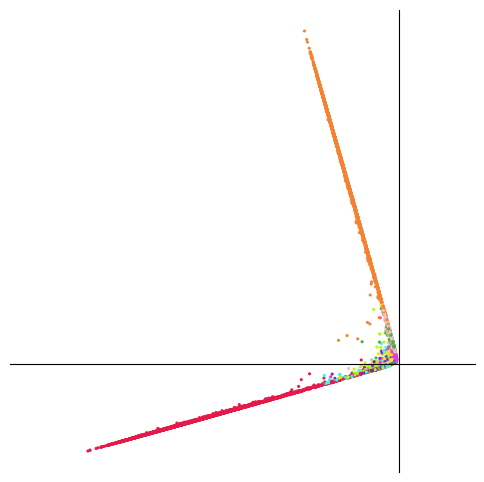

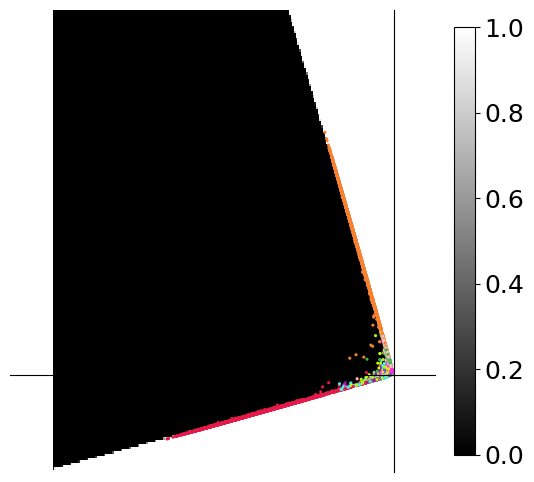

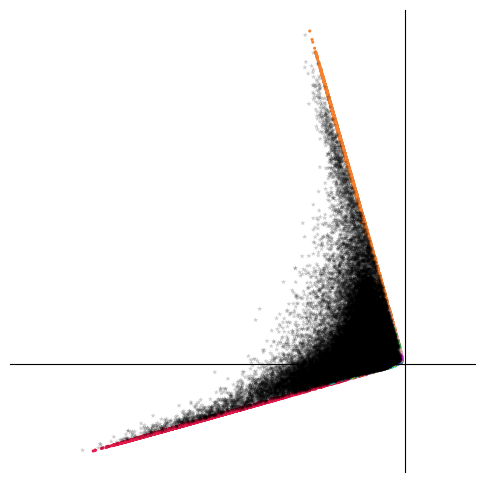

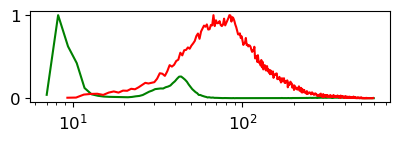

In [38]:
data = train_feats[train_gt != unkn_gt_label]
data_labels = train_gt[train_gt != unkn_gt_label]
neg_features = train_feats[train_gt == unkn_gt_label]

tools.viz.plotter_2D(data, data_labels, neg_features=None,
               final=True, heat_map=False, file_name=None)

tools.viz.plotter_2D(data, data_labels, neg_features=None,
               final=True, heat_map=True, file_name=None, prob_function=get_probs, which=which, net=net)

tools.viz.plotter_2D(data, data_labels, neg_features=neg_features,
               final=True, heat_map=False, file_name=None)

### Test Set - Positives + Negatives

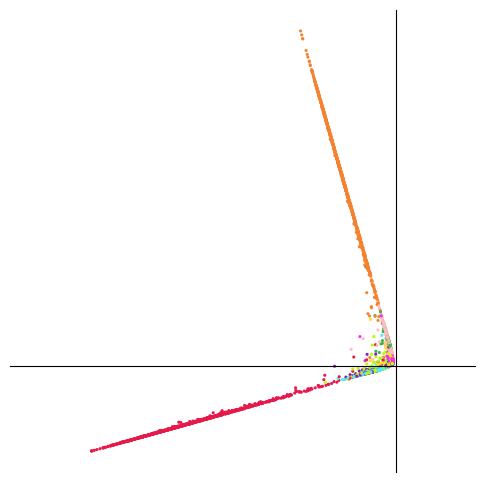

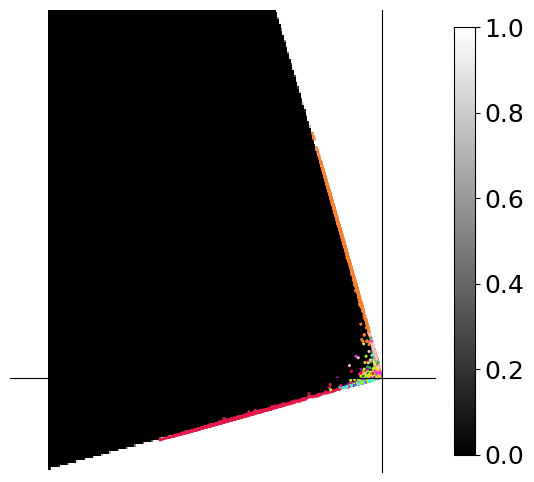

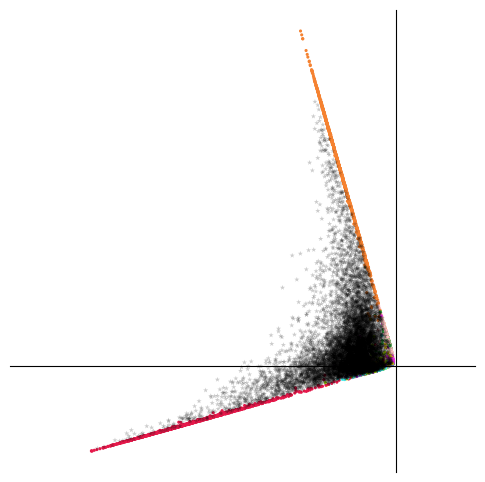

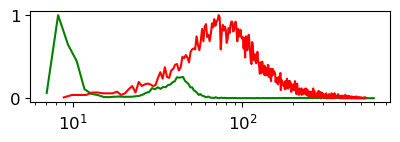

In [39]:
data = test_neg_feats[test_neg_gt != unkn_gt_label]
data_labels = test_neg_gt[test_neg_gt != unkn_gt_label]
neg_features = test_neg_feats[test_neg_gt == unkn_gt_label]

tools.viz.plotter_2D(data, data_labels, neg_features=None,
               final=True, heat_map=False, file_name=None)

tools.viz.plotter_2D(data, data_labels, neg_features=None,
               final=True, heat_map=True, file_name=None, prob_function=get_probs, which=which, net=net)

tools.viz.plotter_2D(data, data_labels, neg_features=neg_features,
               final=True, heat_map=False, file_name=None)

### Test Set - Positivies + Unknowns

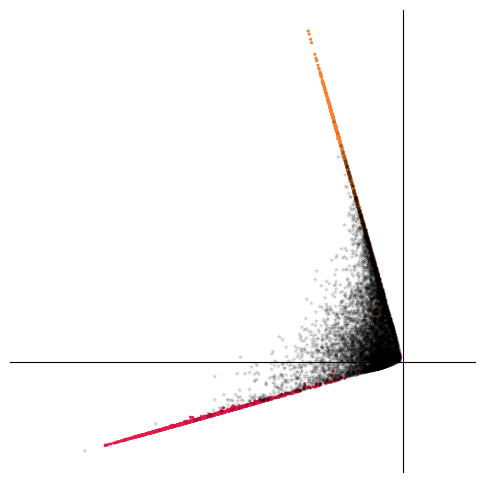

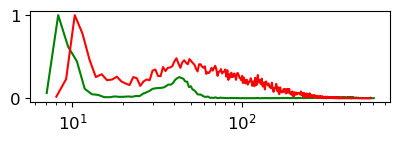

In [40]:
data = test_unkn_feats[test_neg_gt != unkn_gt_label]
data_labels = test_unkn_gt[test_neg_gt != unkn_gt_label]
neg_features = test_unkn_feats[test_neg_gt == unkn_gt_label]

# tools.viz.plotter_2D(data, data_labels, neg_features=None,
#                final=True, heat_map=False, file_name=None)

# tools.viz.plotter_2D(data, data_labels, neg_features=None,
#                final=True, heat_map=True, file_name=None, prob_function=get_probs, which=which, net=net)

tools.viz.plotter_2D(data, data_labels, neg_features=neg_features,
               final=True, heat_map=False, file_name=None)

# Multiple Approaches Visualization

## 1. Learning Curve with Acc, Confi, and so on.

In [20]:
# ! tensorboard --logdir=LeNet_plus_plus

## 2. OSCR Curve

In [7]:
results = {}
for which, net in networks.items():
    if net is None:
        continue
    print ("Evaluating", which)

    # extract positives
    if which == "Garbage":
        test_neg_gt, test_neg_logits, _ = evals.extract(test_set_neg_bg, net)
        test_unkn_gt, test_unkn_logits, _ = evals.extract(test_set_unkn_bg, net)
    else:
        test_neg_gt, test_neg_logits, _ = evals.extract(test_set_neg, net)
        test_unkn_gt, test_unkn_logits, _ = evals.extract(test_set_unkn, net)
        
    # compute probabilities
    if which == "MultiBinary":
        test_neg_probs = F.sigmoid(torch.tensor(test_neg_logits)).detach().numpy()
        test_unkn_probs = F.sigmoid(torch.tensor(test_unkn_logits)).detach().numpy()
    else:
        test_neg_probs = F.softmax(torch.tensor(test_neg_logits), dim=1).detach().numpy()
        test_unkn_probs  = F.softmax(torch.tensor(test_unkn_logits ), dim=1).detach().numpy()

    # remove the labels for the unknown class in case of Garbage Class
    if which == "Garbage":
        test_neg_probs = test_neg_probs[:,:-1]
        test_unkn_probs = test_unkn_probs[:,:-1]
        unkn_gt_label = 10 
    else:
        unkn_gt_label = -1

    # get ccr and fpr by varying a threshold
    print("Test set : Positives + Negatives")
    ccr, fpr_neg = evals.get_oscr_curve(test_neg_gt, test_neg_probs, unkn_gt_label)
    print("Test set : Positives + Unknowns")
    _, fpr_unkn = evals.get_oscr_curve(test_unkn_gt, test_unkn_probs, unkn_gt_label)
    print()
    
    results[which] = (ccr, fpr_neg, fpr_unkn)

Evaluating SoftMax


Test set : Positives + Negatives


100%|██████████| 10000/10000 [00:11<00:00, 867.29it/s]


CCR@FPR0.01 : 0.3953
Test set : Positives + Unknowns


100%|██████████| 10000/10000 [00:11<00:00, 867.65it/s]


CCR@FPR0.01 : 0.1259

Evaluating Garbage
Test set : Positives + Negatives


100%|██████████| 10000/10000 [00:11<00:00, 868.44it/s]


CCR@FPR0.01 : 0.9393
Test set : Positives + Unknowns


100%|██████████| 10000/10000 [00:11<00:00, 868.33it/s]


CCR@FPR0.01 : 0.2219

Evaluating EOS
Test set : Positives + Negatives


100%|██████████| 10000/10000 [00:11<00:00, 858.34it/s]


CCR@FPR0.01 : 0.9223
Test set : Positives + Unknowns


100%|██████████| 10000/10000 [00:11<00:00, 863.34it/s]


CCR@FPR0.01 : 0.3006

Evaluating Objectosphere
Test set : Positives + Negatives


100%|██████████| 10000/10000 [00:11<00:00, 859.87it/s]


CCR@FPR0.01 : 0.9384
Test set : Positives + Unknowns


100%|██████████| 10000/10000 [00:11<00:00, 866.34it/s]


CCR@FPR0.01 : 0.2141

Evaluating MultiBinary
Test set : Positives + Negatives


100%|██████████| 10000/10000 [00:11<00:00, 870.73it/s]


CCR@FPR0.01 : 0.5468
Test set : Positives + Unknowns


100%|██████████| 10000/10000 [00:11<00:00, 880.47it/s]

CCR@FPR0.01 : 0.1242



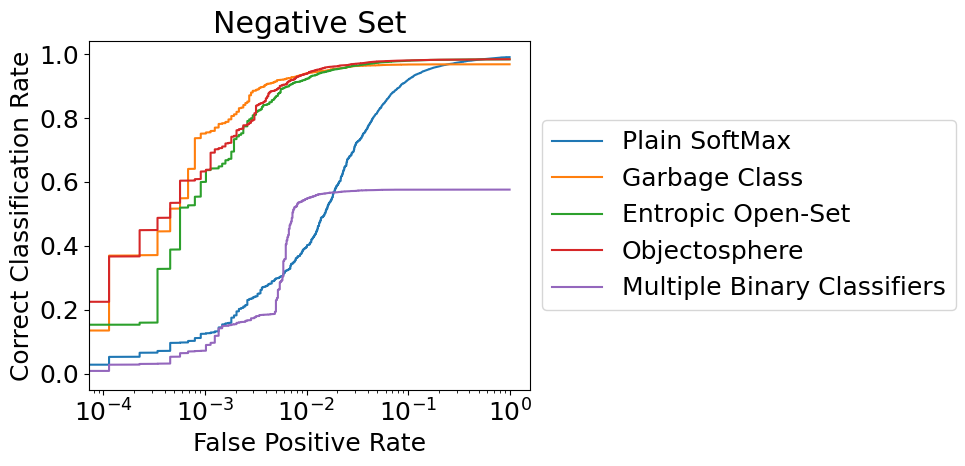

In [8]:
pyplot.figure(figsize=(10,5))
for which, res in results.items():
    pyplot.semilogx(res[1], res[0], label=labels[which])
pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("Correct Classification Rate")
pyplot.title("Negative Set")
pyplot.tight_layout()

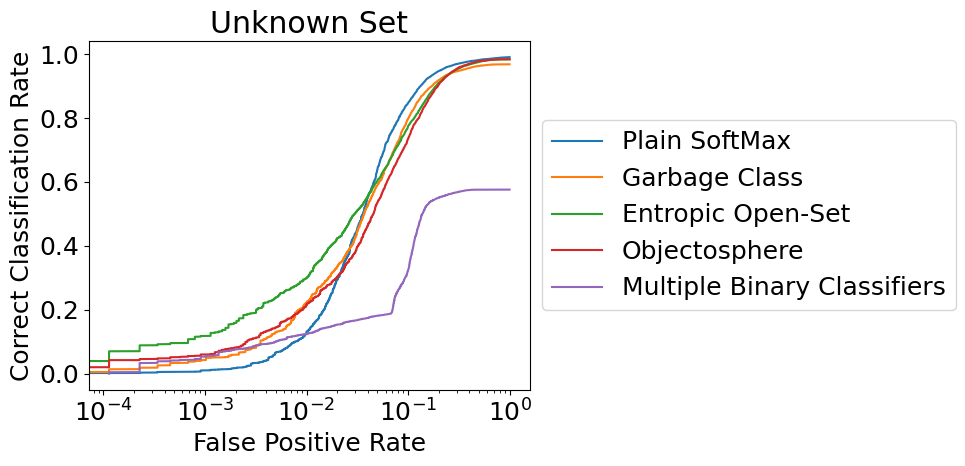

In [9]:
pyplot.figure(figsize=(10,5))
for which, res in results.items():
    pyplot.semilogx(res[2], res[0], label=labels[which])
pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("Correct Classification Rate")
pyplot.title("Unknown Set")
pyplot.tight_layout()